# Semplici esempi su dati di chiusura S&P500 

workbook excel : "S&PMIB Esempio Simulazione.xls"

### Analisi dei Dati

In [14]:
options(warn=-1)
require(binhf)

# individuazione cartella di lavoro
Dirname <- "/working/R"
Dirs <- list.dirs(path=file.path("~"),recursive=T)
dir_wd <- names(unlist(sapply(Dirs,grep,pattern=Dirname))[1])
dir_wd <- paste(dir_wd,'esempi',sep='/')
setwd(dir_wd)
cat("La cartella di lavoro e' : ", getwd())

La cartella di lavoro e' :  C:/Users/User/Documents/GitHub/working/R/esempi

In [15]:
# import del file contenente i dati relativi all'indice S&P MIB
file_name = paste(getwd(), 'ts_sp_mib.csv', sep="/")
ts <- read.csv(file_name, sep=';')
ts$Date = as.Date(ts$Date)

attach(ts)

The following objects are masked from ts (pos = 3):

    Date, Price

The following objects are masked from ts (pos = 4):

    Date, Price



Per effettuare il calcolo dei rendimenti senza alcun loop, shiftiamo il vettore dei prezzi di una posizione e poi calcoliamo il logaritmo del rapporto, in questo modo otteniamo direttamente il vettore dei rendimenti $yield = \ln\Bigl({P_{t-1} \over P_{t}}\Bigr)$

In [16]:
# calcolo rendimenti
shift_price    <- shift(Price,1)
shift_price[1] <- 0
yield <- log(shift_price/Price)
yield[1] <- 0

Plottiamo la distribuzione di frequenza dei rendimenti sulla quale sovrapponiamo una gaussiana teorica con valor medio e standard deviation uguale a quella misurata dalla serie storica. Si noti che dovremmo normalizzare la distribuzione teorica, infatti l'integrale della distribuzione di frequenza riportata sopra è pari a $\Delta x \sum\limits_{i=1}^N f_i$ dove $\Delta x$ è l'ampiezza del bin e $f_i$ il valore della i-esima frequenza.

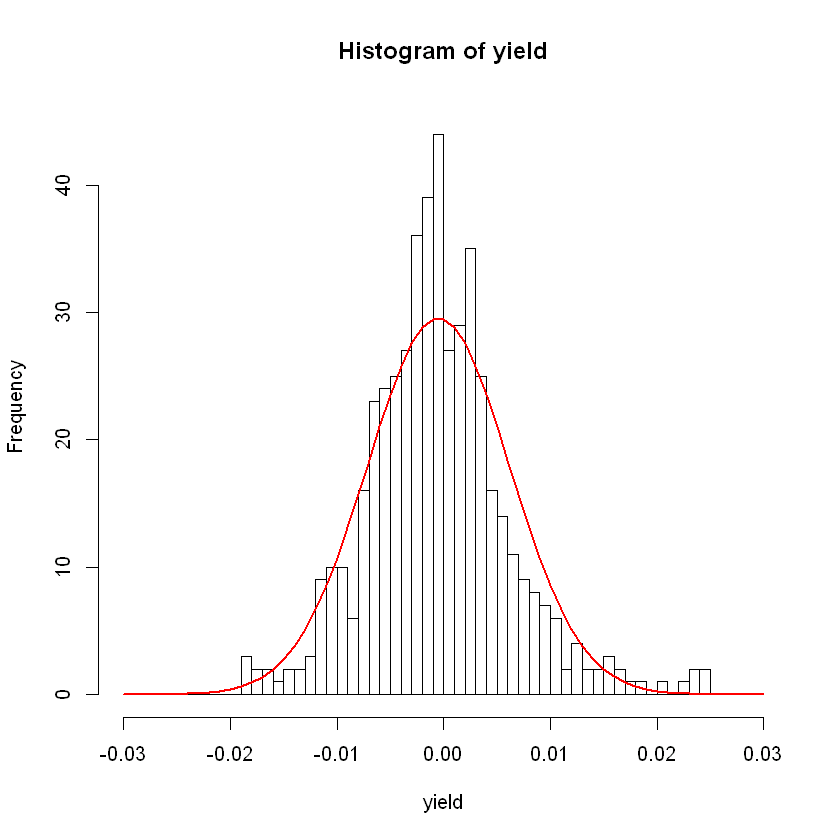

In [17]:
# bin vector
x <- seq(-.03,.03,.001)

# calcolo media e standard deviation
m <- mean(yield)
s <- sqrt(var(yield))

# calcolo il fattore di normalizzazione dell'area
delta <- x[2] - x[1]
ntot  <- length(yield)
A     <- delta * ntot

# normalizzazione x
xn <- (x-m)/s

f <- 1/(s*sqrt(2*pi))
y <- f * exp(-.5*xn*xn) * A

hist(yield,x ,ylim=c(0,45))
lines(x, y, col='red',lwd=2)

## Simulazione

Let’s make up some data, where I add noise by using rnorm() – here I’m generating the same amount of random numbers as is the length of the xseq vector, with a mean of 0 and a standard deviation of 5.5.

In [6]:
xseq<-seq(-4,4,.01)
y<-2*xseq + rnorm(length(xseq),0,5.5)

And now I can plot a histogram of y  and add a curve() function to the plot using the mean and standard deviation of y as the parameters. The curve() function takes as its first parameter a function itself (or an expression) that must be written as some function of x.  Our function here is dnorm(). The x in the dnorm() function is not an object we have created; rather, it’s indicating that there’s a variable that is being evaluated, and the evaluation is the normal density at the mean of y and standard deviation of y. Make sure to include add=TRUE so that the curve is plotted on the same plot as the histogram.  Here is what we get:

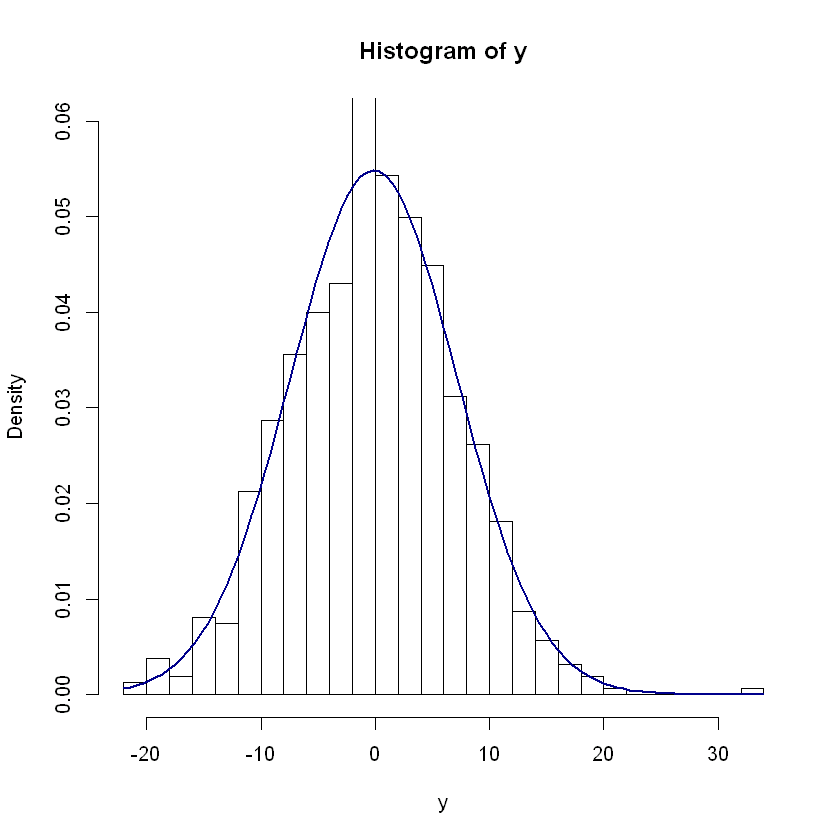

In [7]:
hist(y, prob=TRUE, ylim=c(0,.06), breaks=20)
curve(dnorm(x, mean(y), sd(y)), add=TRUE, col="darkblue", lwd=2)

In [8]:
# the following function simulates a trajectory of Brownian motion at time instants tt

wiener = function( n, tt ) {
  e = rnorm( n, 0, 1 )
  x = c(0,cumsum( e )) / sqrt(n)
  y = x[ 1+floor( n * tt ) ]
  return( list( x = x, y = y ) )
}

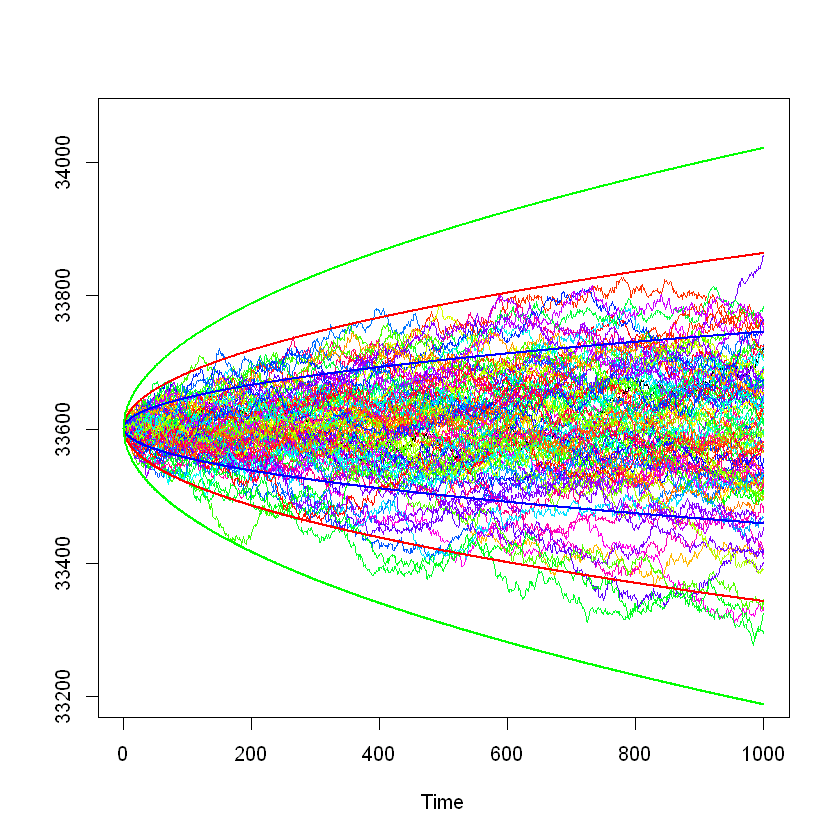

In [9]:
time_step  <- 1000
nsim       <- 100
t          <- seq(0,1,1/time_step)
delta_t <- t[2]-t[1]
# volatilita' normalizzata ad un anno (si assumono 250 giorni lavorativi)
sigma   <- s * sqrt(250) * sqrt(delta_t)
# drift 
drift   <- (m + .5*sigma*sigma)*delta_t
# S0 è inizializzato al valore corrente del prezzo (si assume che il vettore sia ordinato per date crescenti)
S0      <- Price[length(Price)]

# generiamo un path di 500 punti fra 0 e tmax
paths <- wiener(time_step, t )$y
S1    <- S0*exp(drift + sigma * paths)

lower = 0.99*min(S1)
upper = 1.01*max(S1)

plot( S1, type="l",ylim = c(lower,upper), xlab = "Time", ylab="" )

for(i in 1:nsim){
    paths <- wiener(time_step, t )$y
    S     <- S0*exp(drift + sigma * paths)
    lines( S , col=sample(rainbow(100)))
}

# 90-esimo percentile
p <- qnorm(0.9)
y1=S0*exp(drift+p*sigma*sqrt(t))
y2=S0*exp(drift-p*sigma*sqrt(t))
lines(y1, lwd=2,col='blue')
lines(y2, lwd=2,col='blue')

# 99-esimo percentile
p <- qnorm(0.99)
y1=S0*exp(drift+p*sigma*sqrt(t))
y2=S0*exp(drift-p*sigma*sqrt(t))
lines(y1, lwd=2,col='red')
lines(y2, lwd=2,col='red')

# 99.99-esimo percentile
p <- qnorm(0.9999)
y1=S0*exp(drift+p*sigma*sqrt(t))
y2=S0*exp(drift-p*sigma*sqrt(t))
lines(y1, lwd=2,col='green')
lines(y2, lwd=2,col='green')
